## Generate 10kb and 20kb bin files

In [1]:

import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import json
import urllib.request
import logging
import pickle
import importlib
import scipy.sparse as sparse

sys.path.append('/home/camiel/chromograph/')
from chromograph.pipeline import config
from chromograph.preprocessing.utils import *
from chromograph.features.feature_count import *
from chromograph.preprocessing.doublet_finder import doublet_finder

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [101]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)

def mergeBins(f, bin_size):
    with loompy.connect(f, 'r') as ds:
        factor = int(bin_size/5000)
        
        logging.info(f'Getting dense matrix')
        data = ds[:,:].astype('int8')   
        new_data = []

        new_bins = {'chrom' : [], 'start': [], 'end': [], 'loc': []}
        sizes = []
        
        ## Loop over chromosomes to compact bins
        for i in np.unique(ds.ra.chrom):

            ## If no remainder from dividing N original bins by factor
            vals = data[ds.ra.chrom==i,:]
            if vals.shape[0]%factor == 0:
                X = rebin(vals, (int(vals.shape[0]/factor), vals.shape[1]))
            else:
                rem = vals.shape[0]%factor
                X = rebin(vals[:-rem,:], (int(vals.shape[0]/factor), vals.shape[1]))
                X2 = rebin(vals[-rem:,:], (1, vals.shape[1])) ## Merge the last (or last few) bins to one bin
                X = np.vstack((X, X2))

            new_data.append(X.astype('int8'))

            for start, end in zip(ds.ra.start[ds.ra.chrom==i][::factor], ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]):
                new_bins['chrom'].append(i)
                new_bins['start'].append(start)
                new_bins['end'].append(end)
                new_bins['loc'].append(f'{i}:{start}:{end}')

            ## If there was a remainder, name of last bin will be the added to the dictionary
            if len(ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]) < X.shape[0]:
                start = str(int(new_bins['end'][-1]) + 1)
                end = np.max(ds.ra.end[ds.ra.chrom==i])
                new_bins['chrom'].append(i)
                new_bins['start'].append(start)
                new_bins['end'].append(end)
                new_bins['loc'].append(f'{i}:{start}:{end}')

        logging.info(f'Generating sparse matrix')
        matrix = sparse.coo_matrix(np.vstack(new_data)).tocsr()
        
        ## Create loomfile
        logging.info("Constructing loomfile")
        sampleid = f.split('/')[-2] + '_' + str(int(bin_size/1000)) + 'kb'
        floom = os.path.join(os.path.dirname(f), sampleid + '.loom')
        
        loompy.create(filename=floom, 
                      layers=matrix, 
                      row_attrs=new_bins, 
                      col_attrs=ds.ca,
                      file_attrs=f_attrs)
        
        ## Change bin_size in attributes
        with loompy.connect(floom) as dsout:
            dsout.attrs['bin_size'] = bin_size
        
        logging.info(f"Loom-file with {str(int(bin_size/1000)) + 'kb'} bins saved as {floom}")

In [108]:
f = '/data/proj/scATAC/samples/10X232_1/10X232_1_30kb.loom'

if not os.path.exists(f):
    print(os.path.join(os.path.dirname(f), f'{f.split("/")[-2]}_5k.loom'))

/data/proj/scATAC/samples/10X232_1/10X232_1_5k.loom


In [185]:
f = '/data/proj/scATAC/samples/10X232_1/10X232_1_5kb.loom'
bsize = 10000

# del out
with loompy.connect(f, 'r') as ds:
    factor = int(bsize/5000)
    data = ds[:,:].astype('int8')   
    new_data = []

    new_bins = {'chrom' : [], 'start': [], 'end': [], 'loc': []}
    sizes = []
    for i in np.unique(ds.ra.chrom):

        vals = data[ds.ra.chrom==i,:]
        if vals.shape[0]%factor == 0:
            X = rebin(vals, (int(vals.shape[0]/factor), vals.shape[1]))
        else:
            rem = vals.shape[0]%factor
            X = rebin(vals[:-rem,:], (int(vals.shape[0]/factor), vals.shape[1]))
            X2 = rebin(vals[-rem:,:], (1, vals.shape[1]))
            X = np.vstack((X, X2))

        new_data.append(X.astype('int8'))
        
        for start, end in zip(ds.ra.start[ds.ra.chrom==i][::factor], ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]):
            new_bins['chrom'].append(i)
            new_bins['start'].append(start)
            new_bins['end'].append(end)
            new_bins['loc'].append(f'{i}:{start}:{end}')
        
        if len(ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]) < X.shape[0]:
            start = str(int(new_bins['end'][-1]) + 1)
            end = np.max(ds.ra.end[ds.ra.chrom==i].astype('int'))
            new_bins['chrom'].append(i)
            new_bins['start'].append(start)
            new_bins['end'].append(end)
            new_bins['loc'].append(f'{i}:{start}:{end}')
        
        logging.info(f'Finished {i}')
    out = np.vstack(new_data)
print(out.shape)
print(len(new_bins['loc']))

12:22:32 INFO     Finished chr1


(24896, 9510)
24896


In [186]:
[print(x, y) for x, y in zip(new_bins['start'][-5:], new_bins['end'][-5:])]

248915001 248925000
248925001 248935000
248935001 248945000
248945001 248955000
248955001 248956422


[None, None, None, None, None]

In [150]:
totals = np.array([5e3, 1e5, 5e5, 1e6])
DF = np.log10(np.array([1e2, 1e3, 5e3]) + 1)

TF = 1 / totals
IDF = 1/ DF

tf_idf1 = TF * 5000 * IDF[:,None]
tf_idf2 = np.log10(TF*5000 + 1) * IDF[:,None]
print(tf_idf1)
print(tf_idf2)

TF = 5000 / np.log10(totals)
tf_idf3 = (1 / np.log10(totals)) * IDF[:,None]
print(tf_idf3)

print('comparison 1 / 2')
print(tf_idf1/tf_idf2)

print('comparison 1 / 3')
print(tf_idf1*1000/tf_idf3*1000)   

print('comparison 2 / 3')
print(tf_idf2/tf_idf3) 

[[0.49892199 0.0249461  0.00498922 0.00249461]
 [0.33328511 0.01666426 0.00333285 0.00166643]
 [0.27033918 0.01351696 0.00270339 0.0013517 ]]
[[0.15019048 0.01057181 0.00215603 0.0010807 ]
 [0.10032882 0.00706208 0.00144025 0.00072192]
 [0.0813802  0.0057283  0.00116824 0.00058557]]
[[0.13488133 0.0997844  0.08754599 0.08315366]
 [0.09010214 0.06665702 0.05848164 0.05554752]
 [0.07308499 0.05406784 0.0474365  0.04505653]]
comparison 1 / 2
[[3.32192809 2.35968164 2.31407893 2.30833677]
 [3.32192809 2.35968164 2.31407893 2.30833677]
 [3.32192809 2.35968164 2.31407893 2.30833677]]
comparison 1 / 3
[[3698970.00433602  250000.           56989.70004336   30000.        ]
 [3698970.00433602  250000.           56989.70004336   30000.        ]
 [3698970.00433602  250000.           56989.70004336   30000.        ]]
comparison 2 / 3
[[1.11350092 0.1059465  0.02462738 0.01299637]
 [1.11350092 0.1059465  0.02462738 0.01299637]
 [1.11350092 0.1059465  0.02462738 0.01299637]]


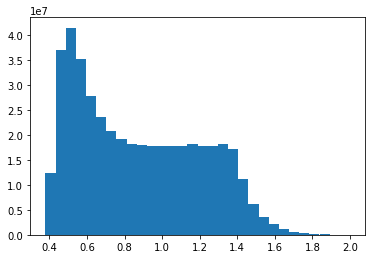

In [148]:
import scipy
f = '/data/proj/scATAC/chromograph/build_20200608/Midbrain/Midbrain.loom'

with loompy.connect(f) as ds:
    v = ds['TF-IDF'].sparse()
    plt.hist(v.data, bins=30)
    

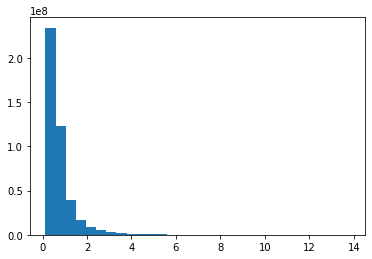

In [149]:
import scipy
f = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain.loom'

with loompy.connect(f) as ds:
    v = ds['TF-IDF'].sparse()
    plt.hist(v.data, bins=30)

(array([2.3744250e+07, 6.6615502e+07, 7.2591691e+07, 7.4588610e+07,
        5.8048523e+07, 3.8085015e+07, 2.6460825e+07, 1.9736248e+07,
        1.4393351e+07, 1.0739374e+07, 8.0832770e+06, 6.0993030e+06,
        4.6707390e+06, 3.7176860e+06, 2.9056850e+06, 2.2511390e+06,
        1.6841070e+06, 1.1998060e+06, 8.3902500e+05, 6.2164900e+05,
        4.2876500e+05, 3.1363800e+05, 2.3105900e+05, 1.6633400e+05,
        1.2709300e+05, 8.8978000e+04, 5.4834000e+04, 2.7526000e+04,
        8.8000000e+03, 1.7510000e+03]),
 array([0.05264, 0.0899 , 0.1272 , 0.1644 , 0.2018 , 0.239  , 0.2764 ,
        0.3135 , 0.3508 , 0.3882 , 0.4253 , 0.4626 , 0.5    , 0.537  ,
        0.5747 , 0.612  , 0.649  , 0.6865 , 0.7236 , 0.7607 , 0.7983 ,
        0.8354 , 0.8726 , 0.91   , 0.9473 , 0.9844 , 1.021  , 1.059  ,
        1.097  , 1.134  , 1.171  ], dtype=float16),
 <a list of 30 Patch objects>)

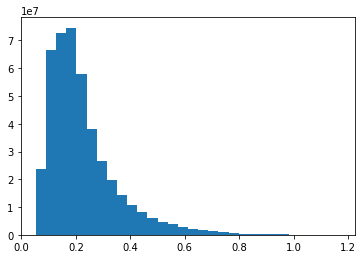

In [153]:
plt.hist(np.log10(v.data+1), bins=30)

In [180]:
TF = (1 / 15000) * 5000
freq = 30000/2000
IDF = np.log10(freq + 1)
print(np.log10(TF/IDF + 1))

IDF = freq
print(np.log10(TF/IDF + 1))

0.10613217383653581
0.009545317906230361


In [156]:
TF/IDF

-0.1111111111111111

In [83]:
print(out.shape)
print(len(new_bins['loc']))

with loompy.connect(f, 'r') as ds:
    print(ds.shape)

(308827, 9510)
308827
(617643, 9510)


In [64]:
data = np.array([[1,0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,0,1], 
                 [1,0,0,0,1,0,1,1], 
                 [1,0,0,1,0,0,0,1],
                 [0,0,0,1,1,0,0,1],
                 [1,0,0,1,0,0,1,0],
                 [1,0,0,1,0,0,1,0],
                 [1,0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,0,1], 
                 [1,0,0,0,1,0,1,1], 
                 [1,0,0,1,0,0,0,1],
                 [0,0,0,1,1,0,0,1],
                 [1,0,0,1,0,0,1,0],
                 [1,0,0,1,0,0,1,0]])

print(data.shape)

factor = 4

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)

if data.shape[0]%factor == 0:
    X = rebin(data, (int(data.shape[0]/factor), data.shape[1]))

else:
    rem = data.shape[0]%factor
    print(rem)
    X = rebin(data[:-rem,:], (int(data.shape[0]/factor), data.shape[1]))
    X2 = rebin(data[-rem:,:], (1, data.shape[1]))
    X = np.vstack((X, X2))
    
print(X)

(14, 8)
2
[[3 0 0 1 1 0 2 3]
 [3 0 0 3 1 0 3 1]
 [2 0 0 2 2 0 1 4]
 [2 0 0 2 0 0 2 0]]


In [39]:
?data.reshape

Docstring:
a.reshape(shape, order='C')

Returns an array containing the same data with a new shape.

Refer to `numpy.reshape` for full documentation.

See Also
--------
numpy.reshape : equivalent function

Notes
-----
Unlike the free function `numpy.reshape`, this method on `ndarray` allows
the elements of the shape parameter to be passed in as separate arguments.
For example, ``a.reshape(10, 11)`` is equivalent to
``a.reshape((10, 11))``.
Type:      builtin_function_or_method
